In [208]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from datetime import datetime
from scipy.stats import logistic
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

%cd "DCP"
import utility, conformal_prediction, conformalized_quantile_regression, distributional_conformal_prediction
from utility import *
from conformal_prediction import *
from conformalized_quantile_regression import *
from distributional_conformal_prediction import *

[WinError 2] 지정된 파일을 찾을 수 없습니다: 'DCP'
C:\Users\윤태성\DCP


## Application 1: Synthetic Data
* Generated a synthetic data where the prediction interval depends on the predictor.
    * e.g., Income (y) and experimence (x), houce prices (y) and square footage of the house (x).
* Data Generating Process : 
$Y_{i} = mX_{i} + c + \epsilon_{i}(X_{i}), \ \epsilon_{i}(X_{i}) \sim N(0, kX_{i})$
    * $\iff Y_{i}|X_{i} \sim N(mX_{i}+c, (kX_{i})^{2})$
* $(1-\alpha)$ Prediction Interval :
    * The prediction interval can be be constructed as $\hat{C}^{gt}_{1-\alpha}(X_{T+1}) = (mX_{T+1}+c-z_{\alpha/2} \times (kX_{T+1}), mX_{T+1}+c + z_{\alpha/2} \times (kX_{T+1}))$ 
    * Then, $P(Y_{T+1} \in \hat{C}^{gt}_{1-\alpha}(X_{T+1})) = 1-\alpha$

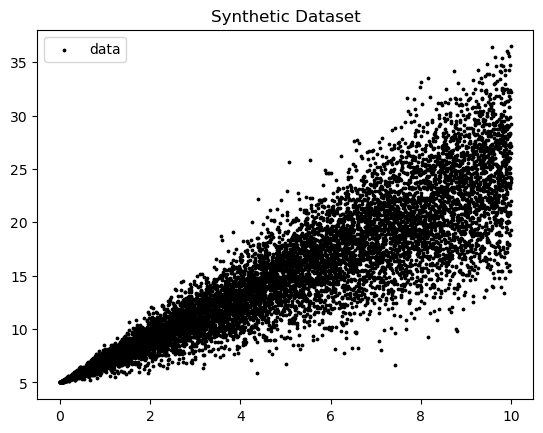

In [209]:
a = 2
b = 5
c = 5  
num_points = 10000
noise_factor = 0.5
test_size = 0.2

X = np.linspace(0, 10, num_points)
Y = a*X + b + noise_factor * X * np.random.randn(num_points).squeeze()
X_train, X_test, Y_train, Y_test = train_test_split(X.reshape(-1,1), Y, test_size=0.2)

To = len(Y_train)   
T_ho = int(len(Y_train) * 0.10) 
ind_cp = np.arange(0, int(np.floor(To*0.50)))
ind_test = np.arange(max(ind_cp)+1, max(ind_cp)+1+T_ho)

Y0, X0, Y1, X1 = aux_uneven(Y_train[ind_cp], X_train[ind_cp, :])

plt.title("Synthetic Dataset")
plt.scatter(X,Y, s = 3, color = "black", label = "data")
plt.legend()

In [210]:
def dcp_dr(Y0, X0, Y1, X1, Y_test, X_test, ys, taus, alpha_sig):
    beta_dr = np.zeros((X0.shape[1] + 1, len(ys)))
    for i, y in enumerate(ys):
        model = sm.Probit((Y0 <= y).astype(int), sm.add_constant(X0))
        res = model.fit(disp=0)
        beta_dr[:, i] = res.params

    tF_yx = sm.add_constant(X1) @ beta_dr
    F_yx = np.sort(tF_yx, axis=1)

    cs = np.array([np.abs(np.interp(y, ys, F_yx[i]) - 0.5) for i, y in enumerate(Y1)])

    tF_test = sm.add_constant(X_test) @ beta_dr
    F_test = np.sort(tF_test, axis=1)

    cs_test = np.array([np.abs(np.interp(y, ys, F_test[i]) - 0.5) for i, y in enumerate(Y_test)])

    k = int(np.ceil((1 - alpha_sig) * (1 + len(Y1))))
    threshold = np.sort(cs)[k - 1]

    cov_dr = cs_test <= threshold

    lb, ub = [], []
    for i in range(len(Y_test)):
        ci = ys[np.abs(F_test[i] - 0.5) <= threshold]
        ub.append(np.max(ci))
        lb.append(np.min(ci))

    LB = np.array(lb)
    UB = np.array(ub)
    leng_dr = UB-LB
    leng_dr[leng_dr == -np.inf] = np.nan

    return UB, LB, cov_dr, leng_dr


In [211]:
taus = np.linspace(0.001, 0.999, 200)
ys = np.quantile(np.unique(np.concatenate((Y0, Y1))), np.linspace(0.001, 0.999, 200))
alpha_sig = 0.1 
critical_value = 1.645

lb_th = a*X_test + b + critical_value * noise_factor * X_test
ub_th = a*X_test + b - critical_value * noise_factor * X_test

ys = np.quantile(np.unique(np.concatenate((Y0, Y1))), np.linspace(0.001, 0.999, 200))
UB_dcp_dr, LB_dcp_dr, cov_dcp_dr, leng_dcp_dr = dcp_dr(Y0, X0, Y1, X1, Y_test, X_test, ys, taus, alpha_sig)
UB_cqr, LB_cqr, UB_cqr_m, LB_cqr_m, UB_cqr_r, LB_cqr_r, cov_cqr_o, cov_cqr_m, cov_cqr_r, leng_cqr_o, leng_cqr_m, leng_cqr = cqr(Y0, X0, Y1, X1, Y_test, X_test, alpha_sig)
UB_cp_reg, LB_cp_reg, cov_cp_reg, leng_cp_reg = cp_reg(Y0, X0, Y1, X1, Y_test, X_test, alpha_sig)
UB_cp_loc, LB_cp_loc, cov_cp_loc, leng_cp_Loc = cp_loc(Y0, X0, Y1, X1, Y_test, X_test, alpha_sig)
UB_dcp_qr, LB_dcp_qr, cov_dcp_qr, leng_dcp_qr = dcp_qr(Y0, X0, Y1, X1, Y_test, X_test, taus, alpha_sig)
UB_dcp_opt, LB_dcp_opt, cov_dcp_opt, leng_dcp_opt = dcp_opt(Y0, X0, Y1, X1, Y_test, X_test, taus, alpha_sig)

In [212]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

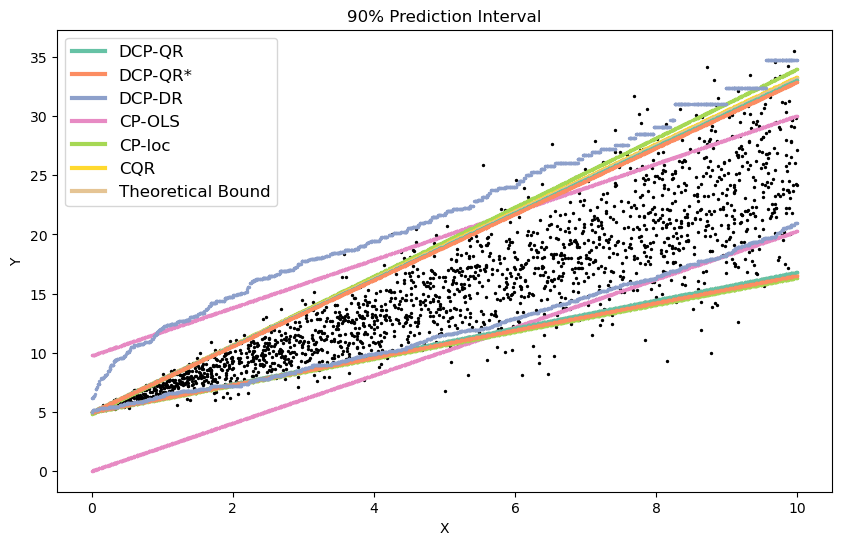

In [213]:
hex_colors = ["#66c2a5","#fc8d62","#8da0cb","#e78ac3","#a6d854","#ffd92f","#e5c494"]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.scatter(X_test, Y_test, s=2, label="Ground truth", color='black')
plt.scatter(X_test, UB_cp_reg, s=2, color=hex_colors[3])
plt.scatter(X_test, LB_cp_reg, s=2, color=hex_colors[3])
plt.scatter(X_test, UB_cp_loc, s=2, color=hex_colors[4])
plt.scatter(X_test, LB_cp_loc, s=2, color=hex_colors[4])
plt.scatter(X_test, UB_cqr, s=2, color=hex_colors[5])
plt.scatter(X_test, LB_cqr, s=2, color=hex_colors[5])
plt.scatter(X_test, lb_th, s=2, color=hex_colors[6])
plt.scatter(X_test, ub_th, s=2, color=hex_colors[6])
plt.scatter(X_test, UB_dcp_qr, s=2, color=hex_colors[0])
plt.scatter(X_test, LB_dcp_qr, s=2, color=hex_colors[0])
plt.scatter(X_test, UB_dcp_opt, s=2, color=hex_colors[1])
plt.scatter(X_test, LB_dcp_opt, s=2, color=hex_colors[1])
plt.scatter(X_test, UB_dcp_dr, s=2, color=hex_colors[2])
plt.scatter(X_test, LB_dcp_dr, s=2, color=hex_colors[2])
#plt.scatter(X_test, UB_cqr_m, s=3, color=hex_colors[6])
#plt.scatter(X_test, LB_cqr_m, s=3, color=hex_colors[6])
#plt.scatter(X_test, UB_cqr_r, s=3, color=hex_colors[7])
#plt.scatter(X_test, LB_cqr_r, s=3, color=hex_colors[7])

# Custom legend handles
legend_elements = [
        Line2D([0], [0], color=hex_colors[0], lw=3, label='DCP-QR'),
    Line2D([0], [0], color=hex_colors[1], lw=3, label='DCP-QR*'),
    Line2D([0], [0], color=hex_colors[2], lw=3, label ='DCP-DR'),
    Line2D([0], [0], color=hex_colors[3], lw=3, label='CP-OLS'),
    Line2D([0], [0], color=hex_colors[4], lw=3, label='CP-loc'),
    Line2D([0], [0], color=hex_colors[5], lw=3, label='CQR'),
    #Line2D([0], [0], color=hex_colors[6], lw=4, label='CQR-m'),
    #Line2D([0], [0], color=hex_colors[7], lw=4, label='CQR-r'),
    Line2D([0], [0], color=hex_colors[6], lw=3, label='Theoretical Bound'),
    #Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=5, label='Ground truth')
]

plt.xlabel('X')
plt.ylabel('Y')
plt.title('90% Prediction Interval')
plt.legend(handles=legend_elements, fontsize = "large")
plt.savefig("DCP")
plt.show()

# Application 2: Real-world Dataset
Description:
Predictor: One possible predictor is AveRooms, which represents the average number of rooms per household.
Response: MedHouseVal, which represents the median house value.

Characteristics:
In the California Housing dataset, house prices (MedHouseVal) often show more variability as the average number of rooms (AveRooms) increases, demonstrating heteroskedasticity.

## Load Data

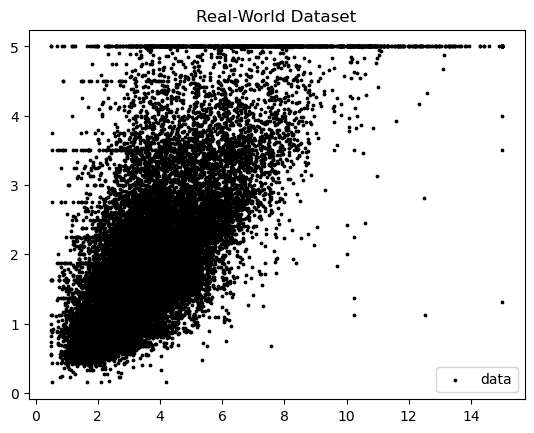

In [214]:
data = fetch_california_housing()
X = data.data[:, np.newaxis, 0]  # Use only one feature for simplicity (MedInc - median income)
Y = data.target

X_train, X_test, Y_train, Y_test = train_test_split(X.reshape(-1,1), Y, test_size=0.2)

To = len(Y_train)   
T_ho = int(len(Y_train) * 0.10) 
ind_cp = np.arange(0, int(np.floor(To*0.50)))
ind_test = np.arange(max(ind_cp)+1, max(ind_cp)+1+T_ho)

Y0, X0, Y1, X1 = aux_uneven(Y_train[ind_cp], X_train[ind_cp, :])

plt.title("Real-World Dataset")
plt.scatter(X,Y, s = 3, color = "black", label = "data")
plt.legend()

## Apply Conformal Prediction Methods

In [215]:
#ys = np.quantile(np.unique(np.concatenate((Y0, Y1))), np.linspace(0.001, 0.999, 200))

# Conformalized Quantile Regression
UB_cqr, LB_cqr, UB_cqr_m, LB_cqr_m, UB_cqr_r, LB_cqr_r, cov_cqr_o, cov_cqr_m, cov_cqr_r, leng_cqr_o, leng_cqr_m, leng_cqr = cqr(Y0, X0, Y1, X1, Y_test, X_test, alpha_sig)

# Standard Conformal Prediction (CP-OLS, CP-loc)
UB_cp_reg, LB_cp_reg, cov_cp_reg, leng_cp_reg = cp_reg(Y0, X0, Y1, X1, Y_test, X_test, alpha_sig)
UB_cp_loc, LB_cp_loc, cov_cp_loc, leng_cp_Loc = cp_loc(Y0, X0, Y1, X1, Y_test, X_test, alpha_sig)

# Distributional Conformal Prediction (DCP-QR, DCP-QR*, DCP-DR)
UB_dcp_qr, LB_dcp_qr, cov_dcp_qr, leng_dcp_qr = dcp_qr(Y0, X0, Y1, X1, Y_test, X_test, taus, alpha_sig)
UB_dcp_opt, LB_dcp_opt, cov_dcp_opt, leng_dcp_opt = dcp_opt(Y0, X0, Y1, X1, Y_test, X_test, taus, alpha_sig)
#UB_dcp_dr, LB_dcp_dr, cov_dcp_dr, leng_dcp_dr = dcp_dr(Y0, X0, Y1, X1, Y_test, X_test, ys, taus, alpha_sig)

## Plot the Prediction Interval

In [216]:
hex_colors

['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494']

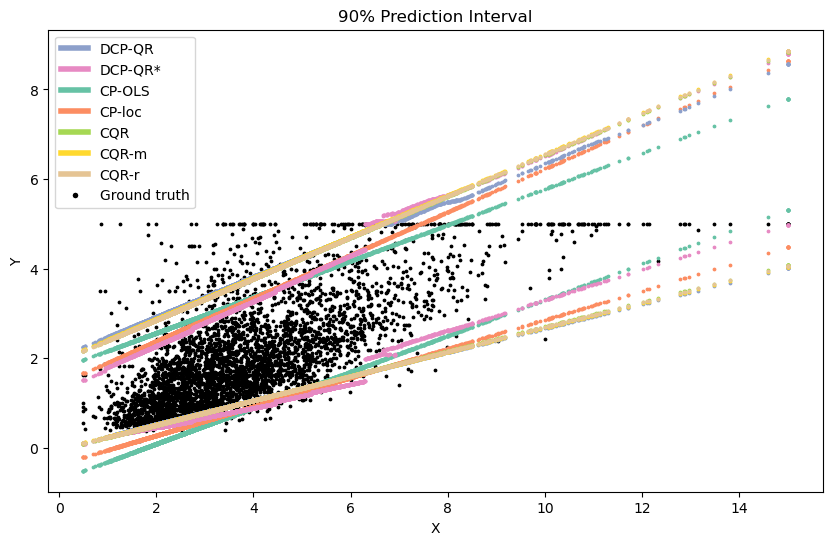

In [217]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Define the hex color codes
hex_colors = ["#66c2a5","#fc8d62","#8da0cb","#e78ac3","#a6d854", "#ffd92f", "#e5c494"]
# Plotting the data
plt.figure(figsize=(10, 6))
plt.scatter(X_test, Y_test, s=3, label="Ground truth", color='black')

plt.scatter(X_test, UB_cp_reg, s=3, color=hex_colors[0])
plt.scatter(X_test, LB_cp_reg, s=3, color=hex_colors[0])
plt.scatter(X_test, UB_cp_loc, s=3, color=hex_colors[1])
plt.scatter(X_test, LB_cp_loc, s=3, color=hex_colors[1])
plt.scatter(X_test, UB_dcp_qr, s=3, color=hex_colors[2])
plt.scatter(X_test, LB_dcp_qr, s=3, color=hex_colors[2])
plt.scatter(X_test, UB_dcp_opt, s=3, color=hex_colors[3])
plt.scatter(X_test, LB_dcp_opt, s=3, color=hex_colors[3])
plt.scatter(X_test, UB_cqr, s=3, color=hex_colors[4])
plt.scatter(X_test, LB_cqr, s=3, color=hex_colors[4])
plt.scatter(X_test, UB_cqr_m, s=3, color=hex_colors[5])
plt.scatter(X_test, LB_cqr_m, s=3, color=hex_colors[5])
plt.scatter(X_test, UB_cqr_r, s=3, color=hex_colors[6])
plt.scatter(X_test, LB_cqr_r, s=3, color=hex_colors[6])

# Custom legend handles
legend_elements = [
    Line2D([0], [0], color=hex_colors[2], lw=4, label='DCP-QR'),
    Line2D([0], [0], color=hex_colors[3], lw=4, label='DCP-QR*'),
    Line2D([0], [0], color=hex_colors[0], lw=4, label='CP-OLS'),
    Line2D([0], [0], color=hex_colors[1], lw=4, label='CP-loc'),
    Line2D([0], [0], color=hex_colors[4], lw=4, label='CQR'),
    Line2D([0], [0], color=hex_colors[5], lw=4, label='CQR-m'),
    Line2D([0], [0], color=hex_colors[6], lw=4, label='CQR-r'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=5, label='Ground truth')
]

plt.xlabel('X')
plt.ylabel('Y')
plt.title('90% Prediction Interval')
plt.legend(handles=legend_elements)
plt.show()


## Obtain Conditional Coverage Probability & Length

In [218]:
coverage_probs = []
lengths = []
X_test_vec = []

for r in range(1,6):
    # Define training and holdout samples
    ind_cp = np.arange((r-1)*T_ho, int(np.floor(To*0.50)) + (r-1)*T_ho)
    ind_test = np.arange(max(ind_cp)+1, max(ind_cp)+1+T_ho)

    Y_test = Y[ind_test]
    X_test = X[ind_test, :]
    
    Y0, X0, Y1, X1 = aux_uneven(Y[ind_cp], X[ind_cp, :])
     
    taus = np.linspace(0.001, 0.999, 200)
    ys = np.percentile(np.concatenate((Y0, Y1)), np.linspace(0.001, 99.9, 200))

    _, _, cov_qr, leng_qr = dcp_qr(Y0, X0, Y1, X1, Y_test, X_test, taus, alpha_sig)
    _, _, cov_opt, leng_opt = dcp_opt(Y0, X0, Y1, X1, Y_test, X_test, taus, alpha_sig)
    #res_dr = dcp_dr(Y0, X0, Y1, X1, Y_test, X_test, ys, taus, alpha_sig)
    _,_,_,_,_,_,cov_o, cov_m, cov_r, leng_o, leng_m, leng_r= cqr(Y0, X0, Y1, X1, Y_test, X_test, alpha_sig)
    _,_, cov_reg, leng_reg = cp_reg(Y0, X0, Y1, X1, Y_test, X_test, alpha_sig)
    _,_, cov_loc, leng_loc = cp_loc(Y0, X0, Y1, X1, Y_test, X_test, alpha_sig)

    X_test_vec.extend(X_test.flatten())

    # Return results
    cov_mat_temp = np.column_stack((cov_qr, cov_opt, cov_o, cov_m, cov_r, cov_reg, cov_loc))
    leng_mat_temp = np.column_stack((leng_qr, leng_opt, leng_o, leng_m, leng_r, leng_reg, leng_loc))
    
    coverage_probs.append(cov_mat_temp)
    lengths.append(leng_mat_temp)
    
coverage_probs = np.vstack(coverage_probs)
lengths = np.vstack(lengths)

## Conditional Coverage Probability of 90% Prediction Interval

In [223]:
hex_colors

['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494']

[0.87086614 0.87244094 0.84494246 0.84324652 0.84712296 0.86747426
 0.86505148]
[3.17195097 2.51050155 2.9674436  3.04753594 2.97146784 2.64819689
 2.60621102]


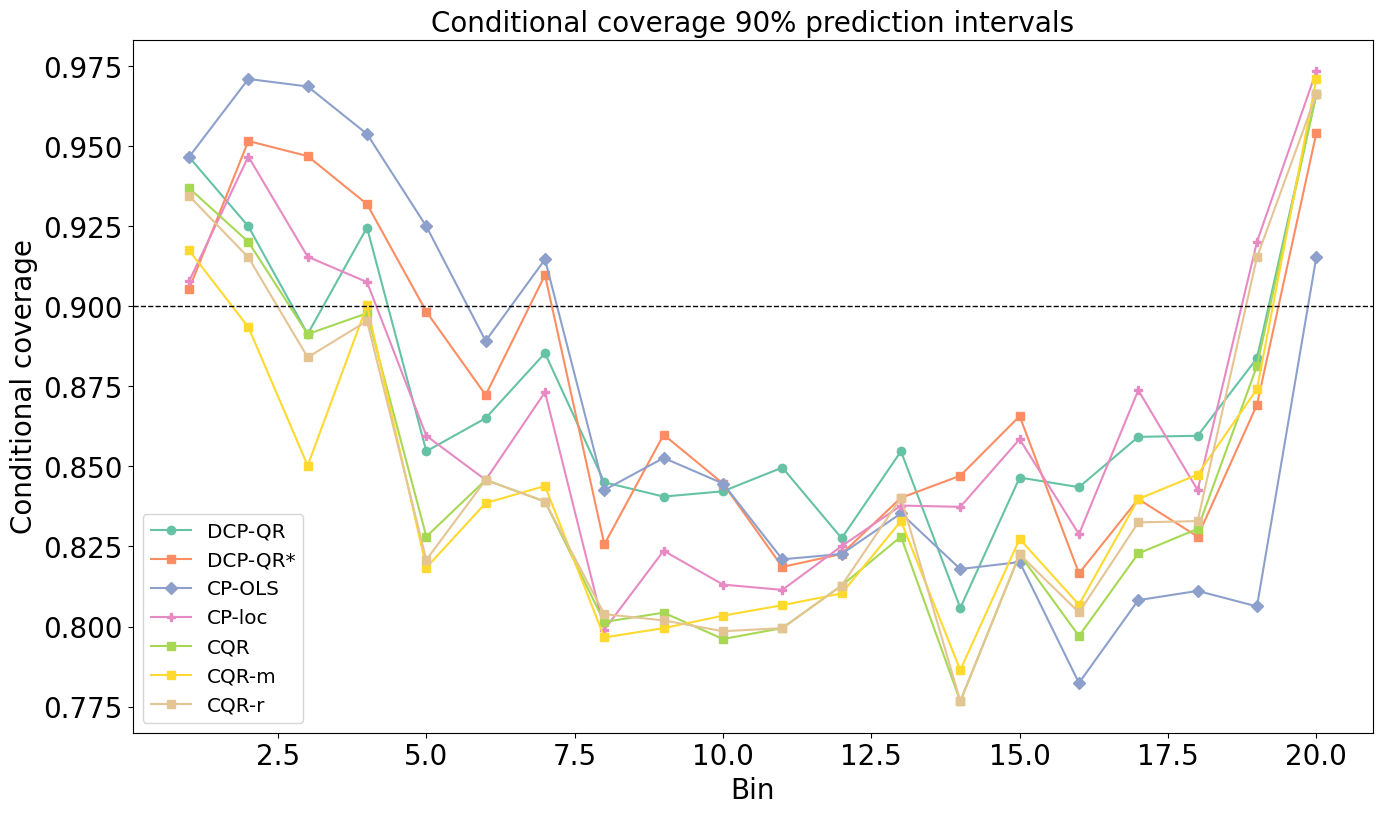

In [236]:
# Save results
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
np.savez_compressed(f"return_{current_time}.npz", cov_mat = coverage_probs, leng_mat = lengths)

# Average length
print(np.mean(coverage_probs, axis=0))
print(np.mean(lengths, axis=0))

# Conditional length and conditional coverage
num_seg = 20
cov_cond = np.zeros((num_seg, 7))
leng_cond = np.zeros((num_seg, 7))
cov_cond = binning(X_test_vec, coverage_probs, num_seg)['cond']
leng_cond = binning(X_test_vec, lengths, num_seg)['cond']

plt.figure(figsize=(16, 9))
plt.plot(np.arange(1, num_seg+1), cov_cond[:,0], marker='o', color = hex_colors[0], label='DCP-QR', linestyle='-')
plt.plot(np.arange(1, num_seg+1), cov_cond[:,1], marker='s', color = hex_colors[1], label='DCP-QR*', linestyle='-')
plt.plot(np.arange(1, num_seg+1), cov_cond[:,5], marker='D', color = hex_colors[2], label='CP-OLS', linestyle='-')
plt.plot(np.arange(1, num_seg+1), cov_cond[:,6], marker='P', color = hex_colors[3], label='CP-loc', linestyle='-')
plt.plot(np.arange(1, num_seg+1), cov_cond[:,2], marker='s', color = hex_colors[4], label='CQR', linestyle='-')
plt.plot(np.arange(1, num_seg+1), cov_cond[:,3], marker='s', color = hex_colors[5], label='CQR-m', linestyle='-')
plt.plot(np.arange(1, num_seg+1), cov_cond[:,4], marker='s', color = hex_colors[6], label='CQR-r', linestyle='-')
#plt.plot(np.arange(1, num_seg+1), cov_cond[:,5], marker='^', label='DCP-DR', linestyle='-', color='r')
plt.axhline(y=0.9, linestyle='--', color='k', linewidth=1)
plt.xlabel('Bin', fontsize = 20)
plt.ylabel('Conditional coverage', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Conditional coverage 90% prediction intervals', fontsize = 20)
plt.legend(fontsize = "x-large")
plt.savefig("cond_cov.png")

### Conditional Length of 90% Prediction Interval

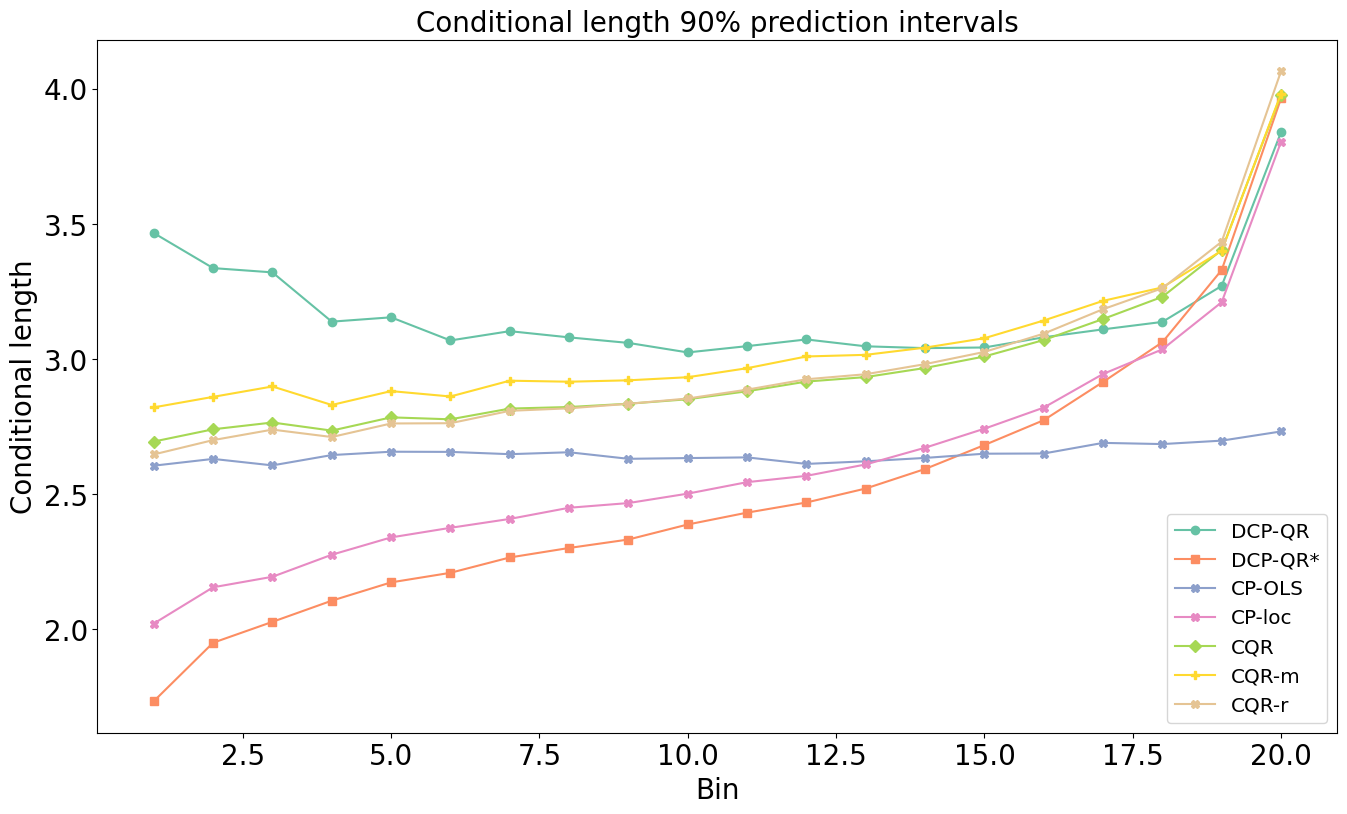

In [237]:
plt.figure(figsize=(16, 9))
plt.plot(np.arange(1, num_seg+1), leng_cond[:, 0], marker='o', color = hex_colors[0], label='DCP-QR', linestyle='-')
plt.plot(np.arange(1, num_seg+1), leng_cond[:, 1], marker='s', color = hex_colors[1], label='DCP-QR*', linestyle='-')
#plt.plot(np.arange(1, num_seg+1), leng_cond[:, 5], marker='^', label='DCP-DR', linestyle='-')
plt.plot(np.arange(1, num_seg+1), leng_cond[:, 5], marker='X', color = hex_colors[2], label='CP-OLS', linestyle='-')
plt.plot(np.arange(1, num_seg+1), leng_cond[:, 6], marker='X', color = hex_colors[3], label='CP-loc', linestyle='-')
plt.plot(np.arange(1, num_seg+1), leng_cond[:, 2], marker='D', color = hex_colors[4], label='CQR', linestyle='-')
plt.plot(np.arange(1, num_seg+1), leng_cond[:, 3], marker='P', color = hex_colors[5], label='CQR-m', linestyle='-')
plt.plot(np.arange(1, num_seg+1), leng_cond[:, 4], marker='X', color = hex_colors[6], label='CQR-r', linestyle='-')

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel("Bin", fontsize = 20)
plt.ylabel("Conditional length", fontsize = 20)
plt.title("Conditional length 90% prediction intervals", fontsize = 20)
plt.legend(fontsize = "x-large")
plt.savefig("cond_pi.png")

In [222]:
methods = ["DCP-QR","DCP-QR*","CQR","CQR-m","CQR-r","CP-ols","CP-loc"]
average_length = leng_cond.mean(0).round(3)

df = pd.DataFrame({
    "Method": methods,
    "Average Length": average_length
})
df_transposed = df.T
df_transposed.columns = df_transposed.iloc[0]
df_transposed = df_transposed.drop(df_transposed.index[0])
average_length = df_transposed
average_length

Method,DCP-QR,DCP-QR*,CQR,CQR-m,CQR-r,CP-ols,CP-loc
Average Length,3.172,2.511,2.967,3.048,2.972,2.648,2.606


In [207]:
variance_cov_prob = (((np.array([cov_cond[:,i].var() for i in range(7)]))) * 1000).round(3)
df = pd.DataFrame({
    "Method": methods,
    "Variance ":variance_cov_prob
})
df_transposed = df.T
df_transposed.columns = df_transposed.iloc[0]
df_transposed = df_transposed.drop(df_transposed.index[0])
variance = df_transposed
variance

Method,DCP-QR,DCP-QR*,CQR,CQR-m,CQR-r,CP-ols,CP-loc
Variance,1.626,2.075,2.641,2.113,2.654,3.592,2.238
